# **Data Preparation**

## **Variable Encoding**

In [1]:
from pandas import read_csv, DataFrame
from dslabs_functions import get_variable_types, encode_cyclic_variables, dummify

data: DataFrame = read_csv("class_ny_arrests.csv", index_col="ARREST_KEY", na_values="")

arrest_boro: dict[str, int] = {"Q": 1, "M": 2, "K": 3, "B": 4, "S": 5}
perp_races: dict[str, int] = {"UNKNOWN": 0, "BLACK": 1, "WHITE HISPANIC": 2, "BLACK HISPANIC": 3,
                              "WHITE": 4, "ASIAN / PACIFIC ISLANDER": 5, "AMERICAN INDIAN/ALASKAN NATIVE": 6, "OTHER": 7}
law_cat_cd: dict[str, int] = {"M": 0, "F": 1}

encoding: dict[str, dict[str, int]] = {
    "ARREST_BORO": arrest_boro,
    "PERP_RACE": perp_races,
    "LAW_CAT_CD": law_cat_cd,
    "PERP_SEX": law_cat_cd,
}
data: DataFrame = data.replace(encoding, inplace=False)
data.head()

,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
ARREST_KEY,,,,,,,,,,,,,,,,,
32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,1.0,18-24,0,1,NaN,NaN,NaN,NaN
192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0.0,45-64,0,1,1000555.0,230994.0,40.800694,-73.941109
193260691,02/06/2019,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0.0,25-44,0,0,986685.0,215375.0,40.757839,-73.991212
149117452,01/06/2016,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0.0,25-44,0,1,998032.0,175598.0,40.648650,-73.950336
190049060,11/15/2018,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0.0,25-44,0,1,1003606.0,185050.0,40.674583,-73.930222


In [2]:
age_group_mapping = {
    '<18': 1,
    '18-24': 2,
    '25-44': 3,
    '45-64': 4,
    '65+': 5,
    'UNKNOWN': 0
}

data["AGE_GROUP"] = data["AGE_GROUP"].apply(
    lambda x: age_group_mapping.get(x, 0)  # Map valid groups; default to 0 for invalid
)

data.head()

,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
ARREST_KEY,,,,,,,,,,,,,,,,,
32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,1.0,2,0,1,NaN,NaN,NaN,NaN
192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0.0,4,0,1,1000555.0,230994.0,40.800694,-73.941109
193260691,02/06/2019,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0.0,3,0,0,986685.0,215375.0,40.757839,-73.991212
149117452,01/06/2016,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0.0,3,0,1,998032.0,175598.0,40.648650,-73.950336
190049060,11/15/2018,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0.0,3,0,1,1003606.0,185050.0,40.674583,-73.930222


In [3]:
import pandas as pd
from math import pi, sin, cos

# Função para codificar variáveis cíclicas
def encode_cyclic_variables(data: DataFrame, vars: list[str]) -> None:
    for v in vars:
        x_max = max(data[v])  # Valor máximo da variável
        data[v + "_sin"] = data[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        data[v + "_cos"] = data[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    return data

# Transformar a coluna "ARREST_DATE"
data["ARREST_DATE"] = pd.to_datetime(data["ARREST_DATE"], format="%m/%d/%Y")
data["Year"] = data["ARREST_DATE"].dt.year
data["Month"] = data["ARREST_DATE"].dt.month
data["Day"] = data["ARREST_DATE"].dt.day

# Criar variáveis cíclicas também para mês (opcional)
data = encode_cyclic_variables(data, ["Month"])

# Remover colunas originais (opcional)
data = data.drop(columns=["ARREST_DATE", "Month"])

data.head()

,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,,,,,
32311380,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,0,1.0,27,1.0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,1,2.0,25,0.0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,NaN,NaN,NaN,NaN,PL 2203400,1,2.0,14,0.0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,153.0,RAPE 3,104.0,RAPE,PL 1302503,1,3.0,67,0.0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,157.0,RAPE 1,104.0,RAPE,PL 1303501,1,3.0,77,0.0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [4]:
# Remover colunas
data = data.drop(columns=["LAW_CODE", "PD_DESC", "KY_CD", "PD_CD"])

data.head()

,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,
32311380,DANGEROUS DRUGS,0,1.0,27,1.0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,SEX CRIMES,1,2.0,25,0.0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,NaN,1,2.0,14,0.0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,RAPE,1,3.0,67,0.0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,RAPE,1,3.0,77,0.0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Criando um LabelEncoder
label_encoder = LabelEncoder()

# Transformando os valores em inteiros
data['OFNS_DESC'] = label_encoder.fit_transform(data['OFNS_DESC'])

data.head()

,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Year,Day,Month_sin,Month_cos
ARREST_KEY,,,,,,,,,,,,,,,,
32311380,14,0,1.0,27,1.0,2,0,1,NaN,NaN,NaN,NaN,2007,18,0.000,-1.000
192799737,66,1,2.0,25,0.0,4,0,1,1000555.0,230994.0,40.800694,-73.941109,2019,26,0.500,0.866
193260691,72,1,2.0,14,0.0,3,0,0,986685.0,215375.0,40.757839,-73.991212,2019,6,0.866,0.500
149117452,64,1,3.0,67,0.0,3,0,1,998032.0,175598.0,40.648650,-73.950336,2016,6,0.500,0.866
190049060,64,1,3.0,77,0.0,3,0,1,1003606.0,185050.0,40.674583,-73.930222,2018,15,-0.500,0.866


In [ ]:
df: DataFrame = data.copy(deep=True)
df.to_csv("datasets/class_ny_arrests_encoding2.csv", index=False)
print(f"Data after encoding: {df.shape}")

Data after encoding: (4968684, 16)


<h3>Methodology After Variable Encoding</h3>

{'accuracy': [0.66515, 0.7516], 'recall': [0.6962190352020861, 0.686831812255541], 'precision': [0.5501184712063459, 0.672453408220577], 'auc': [0.6710211153301591, 0.739360756087219], 'f1': [0.6146055130344709, 0.6795665634674921]}


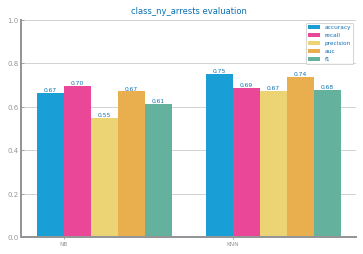

In [ ]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_KNN, run_NB
from sklearn.model_selection import train_test_split
from dslabs_functions import DELTA_IMPROVE
from sklearn.naive_bayes import GaussianNB, BernoulliNB

def run_NB(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    estimators: dict[str, GaussianNB | BernoulliNB] = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }
    best_model: GaussianNB | BernoulliNB = None  # type: ignore
    best_performance: float = 0.0
    eval: dict[str, float] = {}

    for clf in estimators:
        estimators[clf].fit(trnX, trnY)
        prdY: ndarray = estimators[clf].predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = estimators[clf]
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

target = "LAW_CAT_CD"
file_tag = "class_ny_arrests"
filename = "class_ny_arrests.csv"

new_data: DataFrame = read_csv("datasets/class_ny_arrests_encoding2.csv")
new_data = new_data.dropna()

new_data = new_data.head(100000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_encoding_eval2.png")
show()

# **Variable Encoding**
## **Drop Missing Values**

In [ ]:
# Eliminar missing values e "Unknowns" na idade
data: DataFrame = read_csv("datasets\class_ny_arrests_encoding2.csv", na_values="", index_col=None, sep=',', decimal='.')
data = data.dropna()

data = data[data['AGE_GROUP'] != 0]

data = data[data['OFNS_DESC'] != 72]

df: DataFrame = data.copy(deep=True)
df.to_csv("datasets/class_ny_arrests_missing_values2.csv", index=False)
print(f"Data after missing Values: {df.shape}")

Data after missing Values: (4959541, 16)


**Methodology of Missing Values**

{'accuracy': [0.66945, 0.777275], 'recall': [0.6862596862596863, 0.727083727083727], 'precision': [0.5692709694277502, 0.7160317657277578], 'auc': [0.6723253502380621, 0.7686896233130741], 'f1': [0.6223148994515538, 0.7215154262136225]}


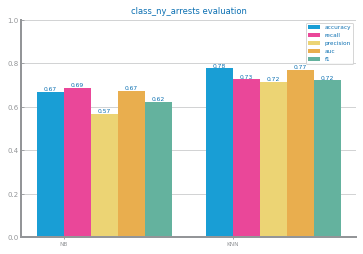

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrests_missing_values2.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_missing_values2_eval.png")
show()

## **Filling missing values**

In [ ]:
# Eliminar missing values e "Unknowns" na idade
data: DataFrame = read_csv("datasets\class_ny_arrests_encoding2.csv", na_values="", index_col=None, sep=',', decimal='.')

data = data.fillna(data.mean())

df: DataFrame = data.copy(deep=True)
df.to_csv("datasets/class_ny_arrests_filling_values2.csv", index=False)
print(f"Data after missing Values: {df.shape}")

Data after missing Values: (4968684, 16)


**Methodology of Filling Values**

{'accuracy': [0.6686, 0.7726], 'recall': [0.6940373293248152, 0.7148315169735688], 'precision': [0.569658646925766, 0.71527951867636], 'auc': [0.6728695425853501, 0.7629038170704575], 'f1': [0.6257270314529336, 0.7150554476536557]}


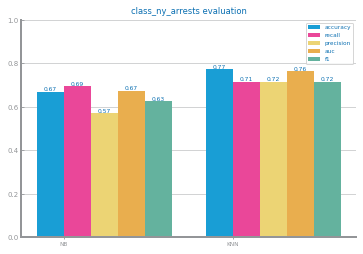

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrests_filling_values2.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_filling_values2_eval.png")
show()

Droping the missing values has a litle better values, so we will use that one

## **Outliers Inputation**
<h3>Drop Outliers</h3>

In [ ]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

data: DataFrame = read_csv("datasets/class_ny_arrests_missing_values2.csv")

print(f"Original train data: {data.shape}")

n_std: int = NR_STDEV
n_std = 9
print("n_std=", n_std)

numeric_vars: list[str] = get_variable_types(data)["numeric"]

if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], threshold= n_std
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv("datasets/class_ny_arrest_drop_outliers2.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")


Original train data: (4959541, 16)
n_std= 9
Data after dropping outliers: (4922194, 16)


**Methodology of Droping Outliers**

{'accuracy': [0.613125, 0.779525], 'recall': [0.05149647887323944, 0.7311368209255533], 'precision': [0.6774193548387096, 0.7190649928885041], 'auc': [0.517655609954548, 0.7712996521626437], 'f1': [0.09571670659732369, 0.7250506625097428]}


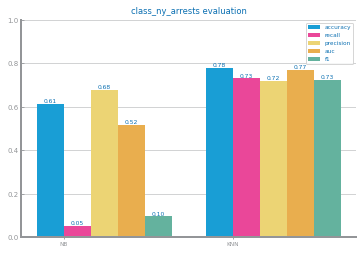

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrest_drop_outliers2.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_drop_outliers_eval2.png")
show()

<h3>Replacing outliers with fixed value</h3>

In [ ]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv("datasets/class_ny_arrests_replacing_outliers2.csv", index=False)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")


Data after replacing outliers: (4959541, 16)
          OFNS_DESC    LAW_CAT_CD   ARREST_BORO  ARREST_PRECINCT  \
count  4.959541e+06  4.959541e+06  4.959541e+06     4.959541e+06   
mean   3.190225e+01  2.970009e-01  2.602124e+00     6.084671e+01   
std    2.227951e+01  4.569370e-01  1.044059e+00     3.416597e+01   
min    0.000000e+00  0.000000e+00  1.000000e+00     1.000000e+00   
25%    1.400000e+01  0.000000e+00  2.000000e+00     3.400000e+01   
50%    2.000000e+01  0.000000e+00  3.000000e+00     5.200000e+01   
75%    5.500000e+01  1.000000e+00  3.000000e+00     8.400000e+01   
max    7.100000e+01  1.000000e+00  4.000000e+00     1.230000e+02   

       JURISDICTION_CODE     AGE_GROUP      PERP_SEX     PERP_RACE  \
count       4.959541e+06  4.959541e+06  4.959541e+06  4.959541e+06   
mean        2.380132e-01  2.922936e+00  1.747053e-01  1.820430e+00   
std         8.484295e-01  6.605288e-01  3.797149e-01  1.027809e+00   
min         0.000000e+00  2.000000e+00  0.000000e+00  0.000000

**Methodology of Replacing Outliers**

{'accuracy': [0.678775, 0.7794], 'recall': [0.46053046053046054, 0.7298557298557299], 'precision': [0.6303897895826147, 0.7186278766825879], 'auc': [0.6414435781742119, 0.7709252951927135], 'f1': [0.5322363391459464, 0.724198287178846]}


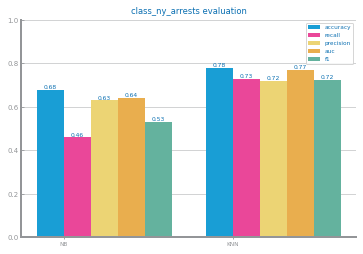

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrests_replacing_outliers2.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_replacing_outliers_eval2.png")
show()

<h3>Truncate outliers</h3>

In [18]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv("datasets/class_ny_arrests_truncate_outliers2.csv", index=False)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")


Data after truncating outliers: (4959541, 16)
          OFNS_DESC    LAW_CAT_CD   ARREST_BORO  ARREST_PRECINCT  \
count  4.959541e+06  4.959541e+06  4.959541e+06     4.959541e+06   
mean   3.190225e+01  2.970009e-01  2.675586e+00     6.084671e+01   
std    2.227951e+01  4.569370e-01  1.134281e+00     3.416597e+01   
min    0.000000e+00  0.000000e+00  1.000000e+00     1.000000e+00   
25%    1.400000e+01  0.000000e+00  2.000000e+00     3.400000e+01   
50%    2.000000e+01  0.000000e+00  3.000000e+00     5.200000e+01   
75%    5.500000e+01  1.000000e+00  4.000000e+00     8.400000e+01   
max    7.100000e+01  1.000000e+00  4.953063e+00     1.230000e+02   

       JURISDICTION_CODE     AGE_GROUP      PERP_SEX     PERP_RACE  \
count       4.959541e+06  4.959541e+06  4.959541e+06  4.959541e+06   
mean        5.033633e-01  2.773335e+00  1.747053e-01  1.929678e+00   
std         2.447908e+00  8.548056e-01  3.797149e-01  1.161020e+00   
min         0.000000e+00  1.034216e+00  0.000000e+00  0.00000

**Methodology of Truncating Outliers**

{'accuracy': [0.681575, 0.779125], 'recall': [0.5441315441315442, 0.7290997290997291], 'precision': [0.610906776064507, 0.7184628755897691], 'auc': [0.6580648602242667, 0.7705680184852897], 'f1': [0.57558895071807, 0.7237422219442795]}


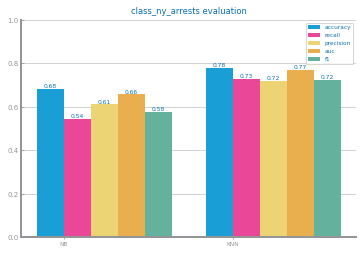

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrests_truncate_outliers2.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_truncate_outliers_eval2.png")
show()

After seeing every diferent case of dealing with the outliers we see that only by droping the outliers we see a very tiny change, so we will use that method.

## **Scaling**
<h3>Methodollogy MinMax Scaler</h3>

In [ ]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

data: DataFrame = read_csv("datasets/class_ny_arrest_drop_outliers2.csv")

target = "LAW_CAT_CD"

# Separate the target column
target_data: Series = data.pop(target).copy()  # Use .copy() to ensure immutability

# Scale only the feature variables
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaled_features = scaler.fit_transform(data)

# Create a DataFrame for the scaled data
df_zscore = DataFrame(scaled_features, columns=data.columns, index=data.index)

# Insert the target variable at the 4th index (Python index 3)
df_zscore.insert(4, target, target_data)

# Save the final DataFrame
df_zscore.to_csv("datasets/class_ny_arrests_scaled_zscore2.csv", index=False)

<h3>Methodollogy Standard Scaler</h3>

{'accuracy': [0.71995], 'recall': [0.6632922535211268], 'precision': [0.6433886313735058], 'auc': [0.7103189355255036], 'f1': [0.6531888544891641]}


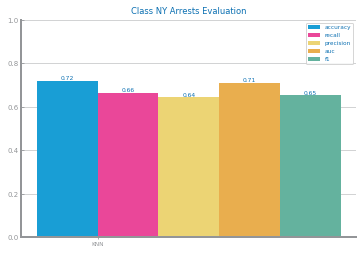

In [ ]:
def evaluate_approach2(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    # Separate features and target variables
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values

    # Evaluate KNN
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    
    # Create evaluation dictionary
    eval: dict[str, list] = {}
    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_KNN[met]]  # Only store KNN results as a single-entry list

    return eval

new_data: DataFrame = read_csv("datasets/class_ny_arrests_scaled_zscore2.csv")
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_minmax: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_minmax)
plot_multibar_chart(
    ["KNN"], eval_minmax, title="Class NY Arrests Evaluation", percentage=True
)
savefig("images/class_ny_arrests_standard_scaler_eval2.png")
show()

<h3>MinMax Scaler</h3>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, Series, read_csv

# Load data
data: DataFrame = read_csv("datasets/class_ny_arrest_drop_outliers2.csv")

target = "LAW_CAT_CD"
vars: list[str] = data.columns.to_list()

# Separate target column
target_data: Series = data.pop(target).copy()

# Apply MinMaxScaler to the remaining columns
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index, columns=data.columns)

# Reinsert the target column at the 4th index
df_minmax.insert(1, target, target_data)

# Rename columns to match original variable names
df_minmax.columns = vars

# Save the resulting DataFrame
df_minmax.to_csv("datasets/class_ny_arrests_scaled_minmax2.csv", index=False)

<h3>Methodollogy MinMax Scaler</h3>

{'accuracy': [0.761975], 'recall': [0.7075578470824949], 'precision': [0.6979470321900391], 'auc': [0.7527248066753776], 'f1': [0.7027195803540762]}


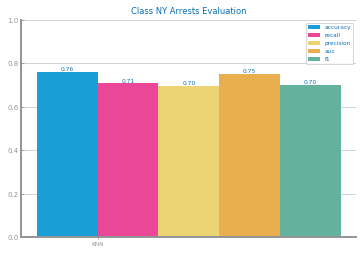

In [ ]:
new_data: DataFrame = read_csv("datasets/class_ny_arrests_scaled_minmax2.csv", na_values="", index_col=None, sep=',', decimal='.')
new_data = new_data.head(200000)

train, test = train_test_split(new_data, test_size=0.2, random_state=42)

figure()
eval_minmax: dict[str, list] = evaluate_approach2(train, test, target=target, metric="recall")
print(eval_minmax)
plot_multibar_chart(
    ["KNN"], eval_minmax, title="Class NY Arrests Evaluation", percentage=True
)
savefig("images/class_ny_arrests_minmax_eval2.png")
show()

Surprisingly, scaling didn't improve the results, so we won't use it.

# **Balancing**

Minority class= 1 : 1461993
Majority class= 0 : 3460201
Proportion: 0.42 : 1


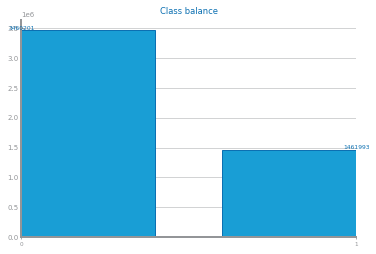

In [ ]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

target = "LAW_CAT_CD"
original: DataFrame = read_csv("datasets/class_ny_arrest_drop_outliers2.csv", sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
savefig("images/class_ny_arrests_balancing.png")
show()

In [46]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

<h3>Undersampling</h3>

In [ ]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv("datasets/class_ny_arrests_under2.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 1461993
Majority class= 0 : 1461993
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.88245, 0.780275], 'recall': [0.9679887960786275, 0.7996798879607863], 'precision': [0.8265214606021781, 0.7696899672636242], 'auc': [0.8824799281037912, 0.7802817893345192], 'f1': [0.8916789531883524, 0.7843983809640622]}


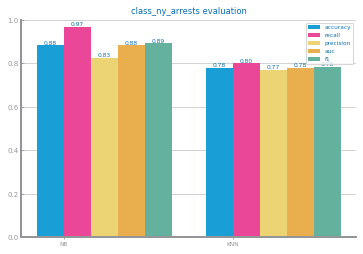

In [ ]:
df_under_head = df_under.head(100000)
df_under_tail = df_under.tail(100000)
df_under = pd.concat([df_under_head, df_under_tail])

df_under = df_under.reset_index(drop=True)

df_under_train, df_under_test = train_test_split(df_under, test_size=0.2, random_state=42)

figure()
eval_undersampling: dict[str, list] = evaluate_approach(df_under_train, df_under_test, target=target, metric="recall")
print(eval_undersampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_undersampling, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_undersampling_eval2.png")
show()

<h3>Oversampling</h3>

In [ ]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)

df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv("datasets/class_ny_arrests_over.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 3460201
Majority class= 0 : 3460201
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.88245, 0.780275], 'recall': [0.9679887960786275, 0.7996798879607863], 'precision': [0.8265214606021781, 0.7696899672636242], 'auc': [0.8824799281037912, 0.7802817893345192], 'f1': [0.8916789531883524, 0.7843983809640622]}


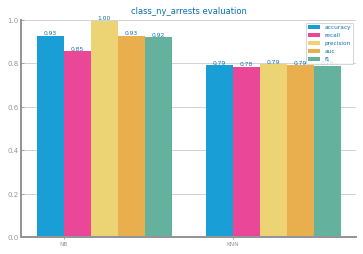

In [ ]:
df_over_head = df_over.head(100000)
df_over_tail = df_over.tail(100000)
df_over = pd.concat([df_over_head, df_over_tail])

df_over = df_over.reset_index(drop=True)

df_over_train, df_over_test = train_test_split(df_over, test_size=0.2, random_state=42)

figure()
eval_oversampling: dict[str, list] = evaluate_approach(df_over_train, df_over_test, target=target, metric="recall")
print(eval_undersampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_oversampling, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_oversampling_eval2.png")
show()

<h3>SMOTE</h3>

In [52]:
!  pip install imbalanced-learn

You should consider upgrading via the 'c:\users\tiago\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv("datasets/class_ny_arrests_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 3460201
Majority class= 0 : 3460201
Proportion: 1.0 : 1
(6920402, 16)


Methodology

{'accuracy': [0.88245, 0.780275], 'recall': [0.9679887960786275, 0.7996798879607863], 'precision': [0.8265214606021781, 0.7696899672636242], 'auc': [0.8824799281037912, 0.7802817893345192], 'f1': [0.8916789531883524, 0.7843983809640622]}


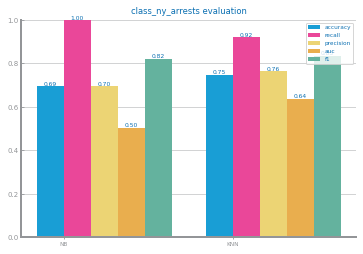

In [ ]:
df_smote_head = df_smote.head(100000)
df_smote_tail = df_smote.tail(100000)
df_smote = pd.concat([df_smote_head, df_smote_tail])

df_smote = df_smote.reset_index(drop=True)

df_smote_train, df_smote_test = train_test_split(df_smote, test_size=0.2, random_state=42)

figure()
eval_smotesampling: dict[str, list] = evaluate_approach(df_smote_train, df_smote_test, target=target, metric="recall")
print(eval_undersampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_smotesampling, title=f"{file_tag} evaluation", percentage=True
)
savefig("images/class_ny_arrests_smotesampling_eval2.png")
show()

<h3>Best model seems to be with Encoding, Drop Missing Values, Drop Outliers, no Scaling and Overfiting</h3>